# Current Strategy

## Importing Libraries

In [74]:
import ta
import pandas as pd
import scipy
import numpy as np
import sklearn
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

## Read in the Data

### From Local Device

<AxesSubplot:>

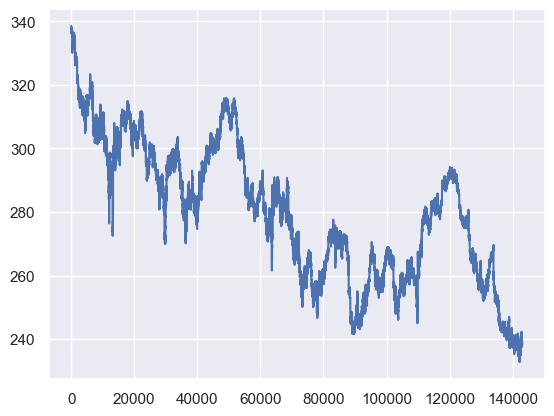

In [99]:
df = pd.read_csv("Data/MSFT 2022 Minute data.csv")
df = df.rename(columns={"open": "Open", "high": "High","low": "Low", "volume": "Volume", "close": "Close"})
df = df.iloc[:143000]
df['Close'].plot()

### From Alpaca

In [ ]:
# import alpaca_trade_api as tradeapi
# import pandas as pd

# api_key = 'PKGASCZ8VKFX6R99BYS7'
# api_secret = 'M8BNGX7Y8e28DJyNaau9bTggM3AZPIURgFHKAMBc'
# base_url = 'https://paper-api.alpaca.markets'  # or use https://api.alpaca.markets for live trading
# rest_client = REST(api_key, api_secret, base_url)
# # api = tradeapi.REST(api_key, api_secret, base_url)

# symbol = 'TSLA'
# timeframe = '1Min'
# start_date = '2021-01-01'
# end_date = '2021-12-31'

# spy_df = rest_client.get_bars(symbol, timeframe, start=start_date, end=end_date).df

# df = spy_df
# df = df.reset_index()
# df = df.rename(columns={"open": "Open", "high": "High","low": "Low", "trade_count": "Volume", "close": "Close", "timestamp": "ts_event"})
# print(symbol)
# df

: 

## Implementing the Rolling Sharpe Ratio and the Indicators

In [81]:
threshold = 0.5

In [82]:
# Assuming risk-free rate is negleted
df['Avg_Return'] = df['Close'].pct_change(1)
df['rolling_mean'] = df['Avg_Return'].rolling(window=15).mean()
df['rolling_sd'] = df['Avg_Return'].rolling(window=15).std()
df['Sharpe_Ratio'] = (df['rolling_mean']/df['rolling_sd']) # Unshifted Sharpe Ratio
def sharpeAssign(value):
    if value > threshold:
        return 2
    elif value < -threshold:
        return 1
    else:
        return 0

df['Long_Short_Hold'] = df['Sharpe_Ratio'].apply(sharpeAssign)


### Experimental Features

In [83]:
# Assuming risk-free rate is negleted
df['Avg_Return'] = df['Close'].pct_change(1)
df['rolling_mean'] = df['Avg_Return'].rolling(window=15).mean()
df['rolling_sd'] = df['Avg_Return'].rolling(window=15).std()
df['Sharpe_Ratio'] = (df['rolling_mean']/df['rolling_sd']) # Unshifted Sharpe Ratio


# Plotting
'''
fig=plt.figure() 
a1=fig.add_axes([0,0,1,1]) 
x=np.arange(1,11) 
a1.plot(df['Sharpe_Ratio'][250:800], 'r-') 
# a1.set_ylabel('exp') 
a2=a1.twinx()
a2.plot(df['Close'][250:800])

'''

df['S_RSI'] = ta.momentum.StochRSIIndicator(close = df['Close'],window = 15).stochrsi()

df['MFI'] = ta.volume.MFIIndicator(high = df['High'], low = df['Low'], close = df['Close'], volume = df['Volume'],window = 15).money_flow_index()

df['ATR'] = ta.volatility.AverageTrueRange(high = df['High'], low = df['Low'], close = df['Close'],window = 15).average_true_range()

df['CCI'] = ta.trend.CCIIndicator(high = df['High'], low = df['Low'], close = df['Close'],window = 15).cci()

df

## Buy = 2
## Sell = 1
## Hold = 0

def sharpeAssign(value):
    if value > threshold:
        return 2
    elif value < -threshold:
        return 1
    else:
        return 0

df['Long_Short_Hold'] = df['Sharpe_Ratio'].apply(sharpeAssign)

Target_variables = ['S_RSI', 'MFI', 'ATR', 'CCI']
for variable in Target_variables:
    df.loc[:,variable] = mstats.winsorize(df.loc[:,variable], limits = [0.1,0.1])


In [84]:
df.head()

,Unnamed: 0.1,Unnamed: 0,ts_event,Open,High,Low,Close,Volume,product_id,ticker,Avg_Return,rolling_mean,rolling_sd,Sharpe_Ratio,Long_Short_Hold,S_RSI,MFI,ATR,CCI
0,0,6,2022-01-03 09:00:00,338.10,338.10,338.10,338.10,5,7119,MSFT,NaN,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
1,1,16,2022-01-03 09:01:00,338.10,338.10,338.00,338.09,13,7119,MSFT,-0.000030,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
2,2,29,2022-01-03 09:02:00,338.09,338.17,338.09,338.17,20,7119,MSFT,0.000237,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
3,3,40,2022-01-03 09:03:00,338.33,338.53,338.30,338.53,471,7119,MSFT,0.001065,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
4,4,51,2022-01-03 09:04:00,338.57,338.57,338.00,338.00,389,7119,MSFT,-0.001566,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386


### PCA Features

In [59]:
# df = dropna(df)
# df.shape

(5965, 15)

In [63]:
# from ta import add_all_ta_features
# from ta.utils import dropna
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler

# # df = dropna(df)

# # Add all technical features
# df = add_all_ta_features(
#     df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# # Take the value columnes
# old_space = df.iloc[:,3:]
# old_space = old_space.drop('ticker', axis = 1)



/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [64]:
# old_space.shape
# # old_space.head()
# # old_space.iloc[680:700,:]

(142986, 97)

In [65]:
# mean = list(old_space.mean())
# # calculate the mean of each column
# column_means = old_space.mean()

# # subtract the column means from the dataframe values
# old_space_centered = old_space - column_means


In [70]:
# old_space_centered.head()
# X = old_space_centered
# X.dropna()
# X.shape

(142986, 97)

In [ ]:
# # from ta import add_all_ta_features
# # from ta.utils import dropna
# # from sklearn.decomposition import PCA
# # from sklearn.preprocessing import MinMaxScaler

# # df = dropna(df)

# # # Add all technical features
# # df = add_all_ta_features(
# #     df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# # # Take the value columnes
# # old_space = df.iloc[:,3:]
# # old_space = old_space.drop('ticker', axis = 1)


# # Create a MinMaxScaler object
# # scaler = MinMaxScaler()

# # Scale the array
# # arr_scaled = scaler.fit_transform(old_space)

# # Create a 2D array X
# # X = arr_scaled

# # Instantiate a PCA object with 5 components
# pca = PCA(n_components=10)

# # Fit and transform the data to get the first 5 principal components
# X_pca = pca.fit_transform(X)

# pd_new = pd.DataFrame(X_pca)
# pd_new['Sharpe_Ratio'] = df['Sharpe_Ratio']
# pd_new['Long_Short_Hold'] = df['Long_Short_Hold']
# pd_new['Close'] = df['Close']
# pd_new['ts_event'] = df['ts_event']
# pd_new

: 

In [107]:
# Target_variables = [0,1,2,3]
# df = pd_new
# for variable in Target_variables:
#     df.loc[:,variable] = mstats.winsorize(df.loc[:,variable], limits = [0.1,0.1])

<AxesSubplot:>

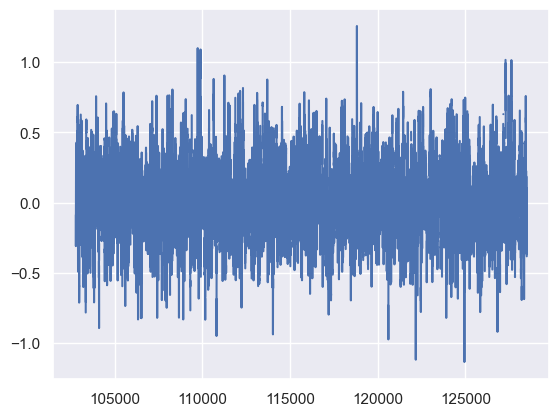

In [108]:
# df['Sharpe_Ratio'][end_train:end_test].plot()

## A dictionary to convert time ticks into date time

In [85]:
time_lookup = {}
temp = [[i,j] for i,j in zip(df.index, df["ts_event"])]
for k in temp:
    time_lookup[k[0]] = k[1]
# time_lookup

## A position class to keep track of the balance

In [ ]:
class position():
    def __init__(self):
        self.balance = 3000
        self.volume = 0

    def buy(self,sr):
        '''
        take in a sharpe ratio that's greater than the threshold, 
        we find the close price and buy 1 share of it
        '''
        self.volume += 1 # this can be adjusted further
        index = df[abs(df['Sharpe_Ratio'] - sr) < 0.000001].index[0]
        self.balance -= df['Close'][index] # subtract the price
        # print("buy at " + str(df['Close'][index]) + " at t = " + str(index))

    def buyati(self,i):
        '''
        buy 1 share at the close price at index i
        '''
        self.volume += 1 # this can be adjusted further
        self.balance -= df['Close'][i] # subtract the price
        # print("buy at " + str(df['Close'][i]) + " at t = " + str(i))

    def sell(self,sr):
        '''
        take in a sharpe ratio that's less than the threshold, 
        we find the close price and sell 1 share of it
        '''
        self.volume -= 1 # this can be adjusted further
        index = df[abs(df['Sharpe_Ratio'] - sr) < 0.000001].index[0]
        self.balance += df['Close'][index] # add the price 
        # print("sell at " + str(df['Close'][index]) + " at t = " + str(index))

    def sellati(self,i):
        '''
        sell 1 share at the close price at index i
        '''
        self.volume -= 1 # this can be adjusted further
        self.balance += df['Close'][i] # subtract the price
        # print("sell at " + str(df['Close'][i]) + " at t = " + str(i))

    def finalBalance(self, time):
        '''
        sell all positions and look at profit
        '''
        self.balance += self.volume * df['Close'][time]
        self.volume = 0
        return self.balance + self.volume * df['Close'][time]


: 

In [ ]:
Izzy = position()
start, finish = 0, len(df)-1
shop = list(df['Sharpe_Ratio'][start:finish])
for i in shop:
    if i > 1:
        Izzy.buy(i)
    if i < -1:
        Izzy.sell(i)
Izzy.finalBalance(finish)

# Stephen = position()
# start, finish = 0, len(df)-1
# shop = list(df['Sharpe_Ratio'][start:finish])
# for i in shop:
#     if i > 0.9:
#         Stephen.buy(i)
#     if i < -0.9:
#         Stephen.sell(i)
# Stephen.finalBalance(finish)

Mia = position()
start, finish = 0, len(df)-1
shop = list(df['Sharpe_Ratio'][start:finish])
for i in shop:
    if i > 0.5:
        Mia.buy(i)
    if i < -0.5:
        Mia.sell(i)
Mia.finalBalance(finish)

print(Izzy.balance, Mia.balance)

## Random Forest Regression

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [89]:
end_train = int(len(df)*0.8)
end_test = len(df)-1
print(time_lookup[end_train], time_lookup[end_test])

train_data = df.loc[:end_train,]
test_data = df.loc[end_train:end_test] 
len(train_data), len(test_data)


2022-08-03 19:25:00 2022-09-29 11:19:00


(114401, 28600)

In [90]:
# Train, Test Split

X_train = train_data.loc[:,Target_variables]
Y_train = train_data.loc[:,['Long_Short_Hold']]
X_test = test_data.loc[:,Target_variables]
Y_test = test_data.loc[:,['Long_Short_Hold']]


#Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train[:], y = Y_train.loc[:,'Long_Short_Hold'], 
#                                 param_name = 'n_estimators', 
#                                 param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)

In [ ]:
co_data = df.copy()
co_train = co_data[:114400]
co_train = co_train.dropna().copy()
co_train

X_train = co_train.loc[:,Target_variables]

Y_train = co_train.loc[:,['Long_Short_Hold']]

#Define paramters from Validation Curve
params = {'max_depth': [5, 7],
        'max_features': ['sqrt'],
        'min_samples_leaf': [10, 15, 20],
        'n_estimators': [5, 7, 9],
        'min_samples_split':[20, 25, 30]} #Using Validation Curves

rf = RandomForestClassifier()

#Perform a TimeSeriesSplit on the dataset
time_series_split = TimeSeriesSplit(n_splits = 3)


rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(X_train, Y_train)
        
#Save the fited variable into a Pickle file
# file_loc = f'{os.getcwd()}\\Pickle_Files\\Cluster_'    
# pickle.dump(rf_cv, open(file_loc,'wb'))

In [96]:
# Predict the classes of the test set
Y_pred = rf_cv.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9567132867132867


In [97]:
import pickle

# open a file to save the pickle data
with open('model.pkl', 'wb') as f:
    # use pickle.dump to save the object to the file
    pickle.dump(rf_cv, f)
    
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [98]:
Izzy = position()

shop = Y_pred
for i in range(len(Y_pred)):
    if Y_pred[i] == 2:
        Izzy.buyati(i+len(train_data))
    if Y_pred[i] == 1:
        Izzy.sellati(i+len(train_data))
Izzy.finalBalance(len(train_data)+len(test_data)-2)


print(Izzy.balance)

sell at 280.3 at t = 114858
sell at 280.29 at t = 114859
sell at 280.79 at t = 115447
sell at 279.47 at t = 115620
sell at 283.25 at t = 116164
sell at 280.46 at t = 116331
sell at 279.83 at t = 117048
sell at 289.13 at t = 118468
sell at 290.83 at t = 119827
sell at 290.75 at t = 119828
sell at 290.42 at t = 119830
sell at 286.87 at t = 122571
sell at 287.04 at t = 122572
sell at 281.07 at t = 123341
sell at 280.68 at t = 123343
sell at 280.55 at t = 123344
sell at 280.46 at t = 123345
sell at 280.15 at t = 123346
sell at 279.86 at t = 123347
sell at 267.65 at t = 126391
sell at 265.32 at t = 126908
sell at 263.62 at t = 127576
sell at 263.96 at t = 127577
sell at 265.0 at t = 128281
sell at 262.48 at t = 128342
sell at 256.43 at t = 129116
sell at 256.52 at t = 129117
sell at 256.16 at t = 129120
sell at 261.13 at t = 129767
sell at 254.22 at t = 130661
sell at 254.35 at t = 130662
sell at 253.77 at t = 130666
sell at 252.57 at t = 130714
sell at 252.55 at t = 130716
sell at 252.52 a

### Unused helpers

In [ ]:
def reduction(U, s, Vt, n):
    temp = [list(i) for i in zip(*U)]
    len(temp), len(temp[0])
    temp = temp[:n]
    U = [list(i) for i in zip(*temp)]
    s = s[:n]
    s = np.diag(s)
    Vt = Vt[:n]
    return np.dot(np.dot(U, s), Vt)

In [ ]:
# old_space = all_data.iloc[60:100,10:54]

import matplotlib.pyplot as plt
plt.imshow(arr_scaled, cmap='gray_r')
plt.title('baseball', fontsize=15, pad=15)
# numpydata.shape
U, s, Vt = np.linalg.svd(arr_scaled)
# old_space.head()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first 2D array in the first subplot
im1 = ax1.imshow(reduction(U, s, Vt, 40), cmap='gray_r')
ax1.set_title('40 singular vlaues')

# Plot the second 2D array in the second subplot
im2 = ax2.imshow(reduction(U, s, Vt, 8), cmap='gray_r')
ax2.set_title('8 singular values')

# Plot the third 2D array in the second subplot
im3 = ax3.imshow(reduction(U, s, Vt, 4), cmap='gray_r')
ax3.set_title('4 singular values')

# Add a colorbar for each subplot
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Display the plot
plt.show()